In [1]:
import os
os.chdir("/content/drive/MyDrive/DREAM")
!ls

 Data		'Dream Olfactory Mixtures Plan.gdoc'   preprocess.ipynb   Trials
 dictionary.pt	 finetune.ipynb			       train.ipynb	  vectorizing.ipynb


In [2]:
!pip install torch-geometric
!pip install info-nce-pytorch

In [3]:
import json
import h5py
import base64
import tqdm
import torch
import torch_geometric as tg
import numpy as np

def decode_smiles(encoded):
    return base64.urlsafe_b64decode(encoded.encode()).decode()

missing = 0
full_dataset = dict()
lim = None

with h5py.File('Data/dataset.h5', 'r') as f:
    for i, encoded_pair in enumerate(tqdm.tqdm(f.keys())):
        pair_str = decode_smiles(encoded_pair)
        pair = json.loads(pair_str)

        group = f[encoded_pair]

        positives = group['positives'][:].astype(str).tolist()
        if not positives:
          missing += 1
          continue

        negatives = group['negatives'][:].astype(str).tolist()
        if not negatives:
          missing += 1
          continue

        graph_group = group['graph']
        graph_data = {k: torch.tensor(np.array(v)) for k, v in graph_group.items()}
        graph_data = {k: v.float() if k != "edge_index" else v.long() for k, v in graph_data.items()}

        full_dataset[tuple(pair)] = {"positives":positives, "negatives":negatives, "graph": tg.data.Data(**graph_data)}

        if lim and i > lim:
            break

len(full_dataset), missing

100%|██████████| 166733/166733 [07:12<00:00, 385.24it/s]


(165192, 1541)

In [4]:
class VectorTokenizer:
  def __init__(self, unique_vector_tuples):
    self.unique_vector_tuples = unique_vector_tuples
    # Create a dictionary to map each vector to its index
    self.vector_to_index = {vector: idx for idx, vector in enumerate(self.unique_vector_tuples)}

  def tokenize(self, vector):
    vector_tuple = tuple(vector.numpy())
    # Break on out of dictionary.
    idx = self.vector_to_index[vector_tuple]
    return torch.tensor(idx, dtype=torch.long)

  def tokenize_batch(self,vectors):
    return torch.stack([self.tokenize(v) for v in vectors])

  def __len__(self):
    return len(self.vector_to_index)

molecule_dictionary = torch.load("dictionary.pt")

x_tokenizer = VectorTokenizer(molecule_dictionary["x"])
edge_tokenizer = VectorTokenizer(molecule_dictionary["edge_attr"])

In [5]:
import uuid
TRIAL_ID_LENGTH = 6
trial_id = str(uuid.uuid4())[:TRIAL_ID_LENGTH]
trial_id

'2f0d1b'

In [6]:
import sklearn
import sklearn.model_selection
test_size = 10000
all_keys = list(full_dataset.keys())
train_keys, test_keys = sklearn.model_selection.train_test_split(all_keys,test_size=test_size)
train_dataset = {k:full_dataset[k] for k in train_keys}
test_dataset = {k:full_dataset[k] for k in test_keys}
len(train_dataset), len(test_dataset)

(155192, 10000)

In [26]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.data import Dataset
import random
random.seed(42)
# Because we are partitioning the dataset, we may not always be able to find
# a positive for each anchor. If we fail after this many tries, we just skip the
# anchor.
lookup_count = 1000

def get_in_dataset(dataset,pair,key):
    smiles = ""
    i = 0
    # We do random searching because each split may or may not have the requisite
    # pairs to form a anchor/positive/negative triplet.
    while not smiles in dataset:
        smiles = tuple(random.choice(dataset[pair][key]))
        i += 1
        if i > lookup_count:
          raise LookupError(f"Couldn't find a valid item for {key}")
    return smiles

def triplet_graph_generator(dataset,repetitions,num_negatives):
    for _ in tqdm.tqdm(range(repetitions)):
      for anchor in dataset.keys():
          try:
            positive = get_in_dataset(dataset,anchor,"positives")
            negatives = [get_in_dataset(dataset,anchor,"negatives") for _ in range(num_negatives)]
            yield anchor, positive, negatives
          except LookupError as e:
            continue

class TripletGraphDataset(Dataset):
    def __init__(self, dataset, repetitions, num_negatives):
        super(TripletGraphDataset, self).__init__()
         # Converting generator to list for len() support
        self.dataset = dataset
        self.data_list = list(triplet_graph_generator(dataset, repetitions, num_negatives))

    def len(self):
        return len(self.data_list)

    def _make_graph(self,key):
        graph = self.dataset[key]["graph"].clone()
        graph.x = x_tokenizer.tokenize_batch(graph.x)
        graph.edge_attr = edge_tokenizer.tokenize_batch(graph.edge_attr)
        return graph

    def get(self, idx):
        anchor, positive, negatives = self.data_list[idx]
        # Could change this to a dictionary
        return self._make_graph(anchor), self._make_graph(positive), [self._make_graph(negative) for negative in negatives]


def triplet_collate_fn(batch):
    anchors, positives, negatives = [], [], []
    for anchor, positive, neg_list in batch:
        anchors.append(anchor)
        positives.append(positive)
        negatives.extend(neg_list)
    return Batch.from_data_list(anchors), Batch.from_data_list(positives), Batch.from_data_list(negatives)

# Need to switch the number of negatives over time (this will mean lowering bsz)
# Create an instance of the custom dataset
# This is quite large. Depending on system ram we may need to rethink the way batches are
# loaded in. There is a large amount of duplication.
# Also, our train and test splits should share no common anchors/pairs.
# Its ok if they have common molecules, but they shouldn't have common blends.
# We could just split the dataset and go from there.

train_reps = 50
train = TripletGraphDataset(train_dataset,train_reps,0)

test_reps = 1
test = TripletGraphDataset(test_dataset,test_reps,0)
print(f"\nTrain = {len(train):,}. Test = {len(test):,}.")
train[0], test[0]

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Train = 7,757,700. Test = 9,738.


((Data(x=[20], edge_index=[2, 36], edge_attr=[36]),
  Data(x=[16], edge_index=[2, 28], edge_attr=[28]),
  []),
 (Data(x=[32], edge_index=[2, 64], edge_attr=[64]),
  Data(x=[24], edge_index=[2, 44], edge_attr=[44]),
  []))

In [8]:
def count_parameters(module):
    return "{:,}".format(sum(p.numel() for p in module.parameters()))

def readout_counts(module):
    results = {"total":count_parameters(module)}
    for n, c in module.named_children():
        results[n] = count_parameters(c)
    return results

In [27]:
import torch.nn as nn
import torch.nn.functional as F

# Shamelessly stolen from (and converted to PytorchGeometric)
# https://lifesci.dgl.ai/_modules/dgllife/model/gnn/mpnn.html
class MPNNGNN(nn.Module):
    """MPNN.

    MPNN is introduced in `Neural Message Passing for Quantum Chemistry
    <https://arxiv.org/abs/1704.01212>`__.

    This class performs message passing in MPNN and returns the updated node representations.

    Parameters
    ----------
    node_in_feats : int
        Size for the input node features.
    node_out_feats : int
        Size for the output node representations.
    edge_in_feats : int
        Size for the input edge features.
    edge_hidden_feats : int
        Size for the hidden edge representations.
    num_step_message_passing : int
        Number of message passing steps.
    """
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats,
                 edge_hidden_feats, num_step_message_passing, dropout):
        super(MPNNGNN, self).__init__()

        # This should be changed to node wise dropout. But maybe not?
        # See https://arxiv.org/pdf/1411.4280
        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.num_step_message_passing = num_step_message_passing
        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(), # Could add dropout after this.
            nn.Linear(edge_hidden_feats, node_out_feats * node_out_feats),
            nn.Dropout(dropout) # This one is after the largest by far.
        )

        self.gnn_layer = tg.nn.conv.NNConv(
            in_channels=node_out_feats,
            out_channels=node_out_feats,
            nn=edge_network,
            aggr='sum' # If this doesn't work, try `aggregator_type='sum'`

        )

        # If we add a second layer, we could add dropout.
        self.gru = nn.GRU(node_out_feats, node_out_feats,bidirectional=False)
        self.final_dropout = nn.Dropout(dropout)


    def forward(self, graph, node_feats, edge_attr):
        """Performs message passing and updates node representations.

        Parameters
        ----------
        g : DGLGraph
            DGLGraph for a batch of graphs.
        node_feats : float32 tensor of shape (V, node_in_feats)
            Input node features. V for the number of nodes in the batch of graphs.
        edge_attr : float32 tensor of shape (E, edge_in_feats)
            Input edge features. E for the number of edges in the batch of graphs.

        Returns
        -------
        node_feats : float32 tensor of shape (V, node_out_feats)
            Output node representations.
        """
        node_feats = self.project_node_feats(node_feats) # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            node_feats = F.relu(self.gnn_layer(node_feats, graph.edge_index, edge_attr))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = self.final_dropout(node_feats.squeeze(0))

        return node_feats

# My sense is that we should have multiple convolutions
# Earlier convolutions have more message passing steps (equivalent to kernel size)
# but smaller node/hidden feature sizes (equivalent to channels).
# AlexNet pools between some of the convolutions.
# I'm unsure what would be the equivalent. How would we merge nodes?
# Also, we could maybe augment the graphs with edges (decrease or increase over time)
class EmbeddedEncoder(torch.nn.Module):
    def __init__(self,node_out_feats,edge_hidden_feats,num_step_message_passing, num_sabs, heads, dropout, **kwargs):
        super(EmbeddedEncoder, self).__init__()
        self.embed_x = torch.nn.Embedding(len(x_tokenizer),node_out_feats)
        self.embed_edge_attr = torch.nn.Embedding(len(edge_tokenizer),edge_hidden_feats)
        self.conv = MPNNGNN(node_in_feats=node_out_feats,edge_in_feats=edge_hidden_feats,node_out_feats=node_out_feats,edge_hidden_feats=edge_hidden_feats,num_step_message_passing=num_step_message_passing,dropout=dropout)
        # https://github.com/davidbuterez/multi-fidelity-gnns-for-drug-discovery-and-quantum-mechanics/blob/3f39d12b66447f62960bf9e4b45070b266328555/schnet_multiple_fidelities/schnet_high_fidelity.py#L159
        # self.readout = tg.nn.aggr.set_transformer.SetTransformerAggregation(node_out_feats,heads=8,num_encoder_blocks=2,num_decoder_blocks=2,dropout=dropout)
        self.readout = tg.nn.aggr.set_transformer.SetTransformerAggregation(node_out_feats,heads=heads,num_encoder_blocks=num_sabs,num_decoder_blocks=num_sabs,dropout=dropout)

    # Cannot get gradient checkpointing to work b/c the SetTransformerAggregation
    # computes dropout internally and doesn't allow checkpointing.
    # We can't combine checkpointing and gradient checkpointing without causing issues.
    # So we could commit to no dropout.
    def forward(self,graph):
        x = self.embed_x(graph.x)
        edge_attr = self.embed_edge_attr(graph.edge_attr)
        x = self.conv(graph,x,edge_attr)
        if "batch" in graph:
            return self.readout(x,graph.batch)
        return self.readout(x)

    def count_parameters(self):
        return {"total":count_parameters(self), "conv":count_parameters(self.conv), "readout":count_parameters(self.readout)}

# model = Encoder()
# model(example["graph"])

# Hyperparameters:

# We will need to rewrite the entire architecture/pipeline for any changes.
# Most Important (in order):
#   Embedding Dictionary (whether to use dictionary)
#   Number of MPNNGNNs
#   Number of Negatives
#   Hard vs Random Negatives

# We will need to do revise batch size and data loading for changes.
# Important:
#   Hidden Sizes
#   Number of Attention Blocks
#   Number of Message Passing Steps
#   Number of Repetitions

# We will probably not be able to tune these (for timing)
# Unimportant:
#   Learning Rate
#   Betas
#   Weight Decay
#   Warmup Fraction

# We could probably use a significantly larger learning rate.
# 10M parameters - 4e-4
# 100M parameters - 2e-4
# 500M parameters - 1e-4
# So for .5M paramters - 1e-3
config = {"embedding":True,"train_steps":len(train),"node_out_feats":64,"edge_hidden_feats":64,"num_step_message_passing":5, "num_sabs":8,"dropout":0.1, "heads":8, "warmup":.05, "lr": 1e-3, "weight_decay":.01, "betas":(.99,.999)}
print(config)
ex_model = EmbeddedEncoder(**config)
print(readout_counts(ex_model))
print(readout_counts(ex_model.conv))

{'embedding': True, 'train_steps': 7757700, 'node_out_feats': 64, 'edge_hidden_feats': 64, 'num_step_message_passing': 5, 'num_sabs': 8, 'dropout': 0.1, 'heads': 8, 'warmup': 0.05, 'lr': 0.0002, 'weight_decay': 0.01, 'betas': (0.99, 0.999)}
{'total': '666,432', 'embed_x': '4,224', 'embed_edge_attr': '704', 'conv': '303,680', 'readout': '357,824'}
{'total': '303,680', 'project_node_feats': '4,160', 'gnn_layer': '274,560', 'gru': '24,960', 'final_dropout': '0'}


In [30]:
import info_nce
import os

def save(path):
  os.makedirs(path,exist_ok=True)
  torch.save({"train_loss":train_losses, "test_loss":test_losses},os.path.join(path,"losses.pt"))
  torch.save(config,os.path.join(path,"config.pt"))
  torch.save(model.state_dict(),os.path.join(path,"model.pt"))

bsz = 2**12
print(f"Batch size of {bsz:,}.")
train_loader = DataLoader(train, batch_size=bsz, shuffle=True, collate_fn=triplet_collate_fn)
# Though we could evaluate with a larger bsz, we don't strictly need to.
test_loader = DataLoader(test, batch_size=bsz, shuffle=True, collate_fn=triplet_collate_fn)

model = EmbeddedEncoder(**config)
optimizer = torch.optim.Adam(model.parameters(),lr=config["lr"], weight_decay=config["weight_decay"], betas=config["betas"])
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=1e-10, end_factor=1, total_iters=config["warmup"]*len(train_loader))

# TODO: Add slanted triangular learning rate
scaler = torch.cuda.amp.GradScaler()

loss_fn = info_nce.InfoNCE()
model.cuda()

iters_per_tl = 50
save_fraction = .1
iters_per_save = int(len(train_loader)*save_fraction)
print(f"Saving every {iters_per_save} steps.")
test_losses = []
train_losses = []
btls = []

def to_gpu(batch):
  anchors, positives, negatives = batch
  return anchors.cuda(), positives.cuda(), [n.cuda() for n in negatives]

def calc_loss(batch):
    anchors, positives, negatives = to_gpu(batch)
    anchor_embeds = model(anchors)
    positives_embeds = model(positives)
    return loss_fn(anchor_embeds,positives_embeds)

def calc_test_loss():
  tls = []
  with torch.no_grad():
    for tbatch in test_loader:
      with torch.cuda.amp.autocast():
        tls.append(calc_loss(tbatch).cpu().detach().numpy())
  return np.mean(tls)

for b, batch in enumerate(tqdm.tqdm(train_loader,smoothing=0)):
    with torch.cuda.amp.autocast():
      loss = calc_loss(batch)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()
    optimizer.zero_grad()

    btls.append(loss.cpu().detach())

    step = b*bsz

    if (b+1) % iters_per_tl == 0:
      # TODO: Instead of keeping track of test_losses and train_losses
      # Use a dictionary and append to it
      # Dictionary should have: test loss, train loss, # of elements seen and also LR
      # We calculate the train loss averaged across a number of train steps.
      train_losses.append(np.mean(btls))
      btls = []
      test_losses.append(calc_test_loss())
      print(f"\Batch {b} (Step {step:,} - Repetition {step/len(train_dataset):.2f}). Train = {train_losses[-1]:.3f}. Test = {test_losses[-1]:.3f}")

    if (b+1) % int(len(train_loader)*save_fraction) == 0:
      print(f"\nCheckpoint at {b}.")
      save(os.path.join("Trials",trial_id,f"step{step}"))

Batch size of 4,096.
Saving every 189 steps.


  3%|▎         | 50/1894 [08:24<5:10:04, 10.09s/it]


Step 49. Train = 8.301. Test = 7.964


  5%|▌         | 100/1894 [16:42<4:59:43, 10.02s/it]


Step 99. Train = 8.262. Test = 7.931


  8%|▊         | 150/1894 [25:11<4:52:52, 10.08s/it]


Step 149. Train = 8.233. Test = 7.900


 10%|▉         | 189/1894 [31:22<4:43:03,  9.96s/it]


Checkpoint at 188.


 11%|█         | 200/1894 [33:29<4:43:39, 10.05s/it]


Step 199. Train = 8.206. Test = 7.865


 13%|█▎        | 250/1894 [41:58<4:36:00, 10.07s/it]


Step 249. Train = 8.179. Test = 7.837


 16%|█▌        | 300/1894 [50:19<4:27:24, 10.07s/it]


Step 299. Train = 8.157. Test = 7.832


 18%|█▊        | 350/1894 [58:39<4:18:46, 10.06s/it]


Step 349. Train = 8.144. Test = 7.817


 20%|█▉        | 378/1894 [1:03:16<4:13:46, 10.04s/it]


Checkpoint at 377.


 21%|██        | 400/1894 [1:07:07<4:10:41, 10.07s/it]


Step 399. Train = 8.136. Test = 7.805


 24%|██▍       | 450/1894 [1:15:23<4:01:53, 10.05s/it]


Step 449. Train = 8.123. Test = 7.791


 26%|██▋       | 500/1894 [1:23:51<3:53:48, 10.06s/it]


Step 499. Train = 8.113. Test = 7.788


 29%|██▉       | 550/1894 [1:32:10<3:45:14, 10.06s/it]


Step 549. Train = 8.107. Test = 7.774


 30%|██▉       | 567/1894 [1:34:53<3:42:04, 10.04s/it]


Checkpoint at 566.


 32%|███▏      | 600/1894 [1:40:31<3:36:47, 10.05s/it]


Step 599. Train = 8.096. Test = 7.777


 34%|███▍      | 650/1894 [1:48:59<3:28:35, 10.06s/it]


Step 649. Train = 8.088. Test = 7.764


 37%|███▋      | 700/1894 [1:57:15<3:20:00, 10.05s/it]


Step 699. Train = 8.087. Test = 7.771


 40%|███▉      | 750/1894 [2:05:43<3:11:46, 10.06s/it]


Step 749. Train = 8.079. Test = 7.754


 40%|███▉      | 756/1894 [2:06:41<3:10:43, 10.06s/it]


Checkpoint at 755.


 42%|████▏     | 800/1894 [2:14:01<3:03:16, 10.05s/it]


Step 799. Train = 8.070. Test = 7.743


 45%|████▍     | 850/1894 [2:22:17<2:54:45, 10.04s/it]


Step 849. Train = 8.069. Test = 7.741


 48%|████▊     | 900/1894 [2:30:46<2:46:31, 10.05s/it]


Step 899. Train = 8.060. Test = 7.751


 50%|████▉     | 945/1894 [2:37:53<2:38:33, 10.02s/it]


Checkpoint at 944.


 50%|█████     | 950/1894 [2:39:01<2:38:01, 10.04s/it]


Step 949. Train = 8.053. Test = 7.727


 53%|█████▎    | 1000/1894 [2:47:22<2:29:37, 10.04s/it]


Step 999. Train = 8.047. Test = 7.724


 55%|█████▌    | 1050/1894 [2:55:38<2:21:10, 10.04s/it]


Step 1049. Train = 8.043. Test = 7.720


 58%|█████▊    | 1100/1894 [3:04:00<2:12:49, 10.04s/it]


Step 1099. Train = 8.037. Test = 7.734


 60%|█████▉    | 1134/1894 [3:09:20<2:06:53, 10.02s/it]


Checkpoint at 1133.


 61%|██████    | 1150/1894 [3:12:12<2:04:20, 10.03s/it]


Step 1149. Train = 8.033. Test = 7.712


 63%|██████▎   | 1200/1894 [3:20:24<1:55:53, 10.02s/it]


Step 1199. Train = 8.034. Test = 7.705


 66%|██████▌   | 1250/1894 [3:28:45<1:47:33, 10.02s/it]


Step 1249. Train = 8.025. Test = 7.721


 69%|██████▊   | 1300/1894 [3:36:58<1:39:08, 10.01s/it]


Step 1299. Train = 8.015. Test = 7.700


 70%|██████▉   | 1323/1894 [3:40:36<1:35:12, 10.01s/it]


Checkpoint at 1322.


 71%|███████▏  | 1350/1894 [3:45:22<1:30:48, 10.02s/it]


Step 1349. Train = 8.014. Test = 7.700


 74%|███████▍  | 1400/1894 [3:53:37<1:22:26, 10.01s/it]


Step 1399. Train = 8.010. Test = 7.695


 77%|███████▋  | 1450/1894 [4:01:51<1:14:03, 10.01s/it]


Step 1449. Train = 8.008. Test = 7.684


 79%|███████▉  | 1500/1894 [4:10:14<1:05:43, 10.01s/it]


Step 1499. Train = 8.001. Test = 7.684


 80%|███████▉  | 1512/1894 [4:12:07<1:03:41, 10.01s/it]


Checkpoint at 1511.


 82%|████████▏ | 1550/1894 [4:18:28<57:21, 10.01s/it]


Step 1549. Train = 7.998. Test = 7.680


 84%|████████▍ | 1600/1894 [4:26:49<49:01, 10.01s/it]


Step 1599. Train = 7.994. Test = 7.673


 87%|████████▋ | 1650/1894 [4:35:04<40:40, 10.00s/it]


Step 1649. Train = 7.991. Test = 7.679


 90%|████████▉ | 1700/1894 [4:43:18<32:19, 10.00s/it]


Step 1699. Train = 7.991. Test = 7.676


 90%|████████▉ | 1701/1894 [4:43:28<32:09, 10.00s/it]


Checkpoint at 1700.


 92%|█████████▏| 1750/1894 [4:51:40<24:00, 10.00s/it]


Step 1749. Train = 7.990. Test = 7.684


 95%|█████████▌| 1800/1894 [4:59:52<15:39, 10.00s/it]


Step 1799. Train = 7.987. Test = 7.661


 98%|█████████▊| 1850/1894 [5:08:17<07:19, 10.00s/it]


Step 1849. Train = 7.983. Test = 7.663


100%|█████████▉| 1890/1894 [5:14:37<00:39,  9.99s/it]


Checkpoint at 1889.


100%|██████████| 1894/1894 [5:15:15<00:00,  9.99s/it]


In [33]:
save(os.path.join("Trials",trial_id))

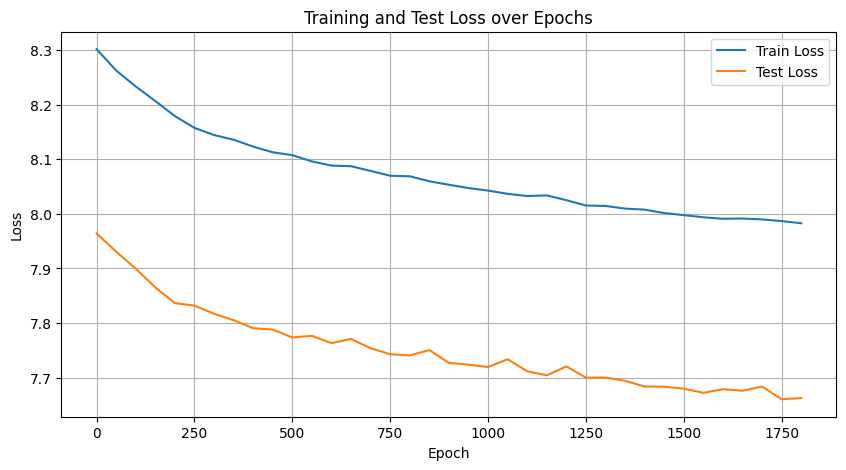

In [32]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot([int(i*iters_per_tl) for i in range(len(train_losses))],train_losses, label='Train Loss')
plt.plot([int(i*iters_per_tl) for i in range(len(test_losses))],test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
# plt.ylim((0,max(train_losses+test_losses)))
plt.legend()
plt.grid(True)
plt.show()

LOAD `4f5a92` AT 6k and then evaluate.

In [29]:
# import gc
# del model
# del batch
# del loss
# del optimizer
# gc.collect()
# torch.cuda.empty_cache()
# optimizer.zero_grad()
# torch.cuda.mem_get_info()

NameError: name 'optimizer' is not defined

In [ ]:
# import sys
# sys.exit()